In [1]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import NMF
from random import random
import matplotlib.pyplot as plt
import boruta

In [17]:
my_data=pd.read_csv('all_data_filtered.csv')
my_data.head(10)
my_data.index=my_data['Patient_id']
my_data=my_data.drop(['Patient_id'],axis=1)
y=my_data['MRD Response']
X=my_data.drop(['MRD Response'],axis=1)

### NMF :

In [3]:
n_samples=X.shape[0]
n_genes=X.shape[1]

In [4]:
class nmf_model():
    def __init__(self,X) :
        self.data=X
        self.n_runs=20
        self.A_k=None
        self.best_k=None
        self.delta_k=None
        self.best_k=None
        self.model=None
        self.W=None
        self.H=None
    
    #Returns consensus matrix, which is the averaged connectivity matrix on several runs of the algorithm
    def get_consensus_matrix(self,n_components):
        model=NMF(n_components,init='random')
        M_k=np.zeros((n_samples,n_samples))
        for i in range (self.n_runs):
            W=model.fit_transform(self.data)
            H=model.components_
            n_metagenes=H.shape[0]

            #calculate Connectivity matrix
            clusters=np.zeros(n_samples)
            C=np.zeros((n_samples,n_samples))

            for i in range (n_samples):
                clusters[i]=np.argmax(H[:,i])

            for i in range (n_samples):
                for j in range (i,n_samples):
                    if (clusters[i]==clusters[j]):
                        C[i,j]=1
                    else:
                        C[i,j]=0
        
            M_k=M_k+C
            return M_k/self.n_runs
        
    #To evaluate model stability
    def get_consensus_distribution (self,M_k):
        list_entries=M_k.ravel()
        hist, bins=np.histogram(list_entries, density=True)
        #calculate CDF
        cdf=np.cumsum(hist)
        return bins, hist, cdf

    def model_selection(self):
        list_k=[10,100]
        self.A_k=np.zeros(len(list_k))
        for i in range(len(list_k)):
            Ck=self.get_consensus_matrix(list_k[i])
            bins,hist,cdf=self.get_consensus_distribution(Ck)
            self.A_k[i] = np.sum(h*(b-a) for b,a,h in zip(bins[1:],bins[:-1],cdf))
        #differences between areas under CDFs
        self.delta_k=np.array([(Ab-Aa)/Aa if i>2 else Aa 
                               for Ab,Aa, i in zip(self.A_k[1:],self.A_k[:-1],range(len(list_k)))])
        self.best_k=list_k[np.argmax(self.delta_k)]
    
    def build_best_model(self):
        self.model=NMF(n_components=self.best_k)
        self.W=self.model.fit_transform(self.data)
        self.H=self.model.components_
        print(self.H)

#### NMF to cluster patients

In [10]:
model=NMF(n_components=2)
W=model.fit_transform(X.T)
H=model.components_

In [15]:
#reordering matrix columns according to MRD response
H_reordered=np.zeros(H.shape)
index_pos=np.where(y==1)[0]
index_neg=np.where(y==0)[0]
H_reordered=np.concatenate((H[:,index_pos],H[:,index_neg]),axis=1)

<Axes: >

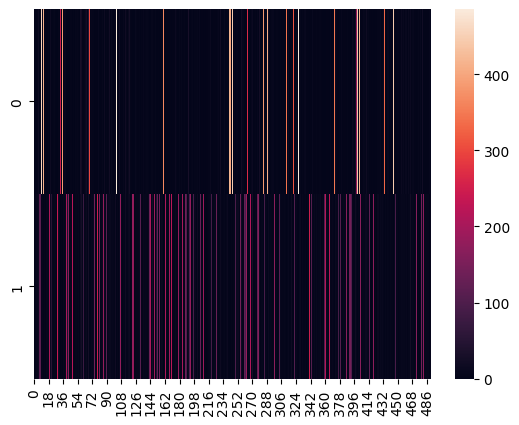

In [16]:
sns.heatmap(H)

<Axes: >

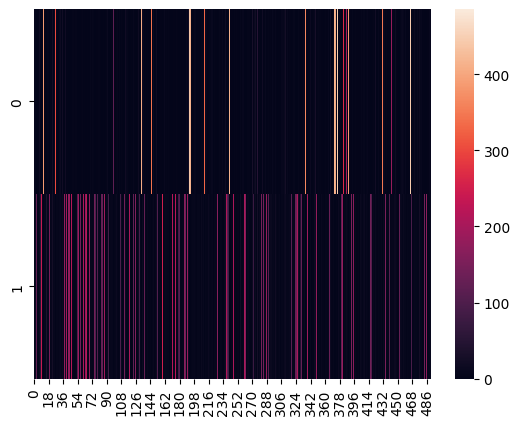

In [17]:
sns.heatmap(H_reordered)

#### NMF to custer genes

In [ ]:
model=nmf_model(X).build_best_model()

In [3]:
model=NMF(n_components=500)
W=model.fit_transform(X)
H=model.components_

In [4]:
W.shape

(491, 100)

In [14]:
X=W

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)
XGBoost=GradientBoostingClassifier(n_estimators=100)
XGBoost=XGBoost.fit(X_train,y_train)

In [16]:
y_pred=XGBoost.predict(X_test)
from sklearn.metrics import accuracy_score
print('accuracy ',accuracy_score(y_pred=y_pred,y_true=y_test) )

accuracy  0.42


### PLS-DA:

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score
y_dummies=pd.get_dummies(y)
mypls=PLSRegression(n_components=2)
H=mypls.fit_transform(X,y)
mypred= mypls.predict(X)
mypred[mypred>0.5]=1
mypred[mypred<0.5]=0
mypred=np.argmax(mypred,axis=1)
from sklearn.metrics import accuracy_score
accuracy_score(mypred,y)
H[1].shape